Practical Homework 3 :Part 3 :

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Species: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Total samples: 1981
Spectrogram Min: -80.0000, Max: 0.0000
Skipping log1p (already log-scaled spectrogram detected)
Epoch 1/30
44/44 - 375s - 9s/step - accuracy: 0.2006 - loss: 3.5948 - val_accuracy: 0.0135 - val_loss: 12.9312
Epoch 2/30
44/44 - 367s - 8s/step - accuracy: 0.2879 - loss: 2.4466 - val_accuracy: 0.0236 - val_loss: 23.1609
Epoch 3/30
44/44 - 387s - 9s/step - accuracy: 0.3153 - loss: 2.4009 - val_accuracy: 0.0236 - val_loss: 29.7811
Epoch 4/30
44/44 - 366s - 8s/step - accuracy: 0.3175 - loss: 2.3762 - val_accuracy: 0.0202 - val_loss: 33.7821
Epoch 5/30
44/44 - 393s - 9s/step - accuracy: 0.3153 - loss: 2.3574 - val_accuracy: 0.0202 - val_loss: 36.1580
Epoch 6/30
44/44 - 384s - 9s/step - accuracy: 0.3189 - loss: 2.3160 - val_accuracy: 0.0168 - val_loss: 35.8484
Epoch 7/30
44/44 - 373s - 8s/step - accuracy: 0.3189 - loss: 2.3522 - val_accuracy: 0.02

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


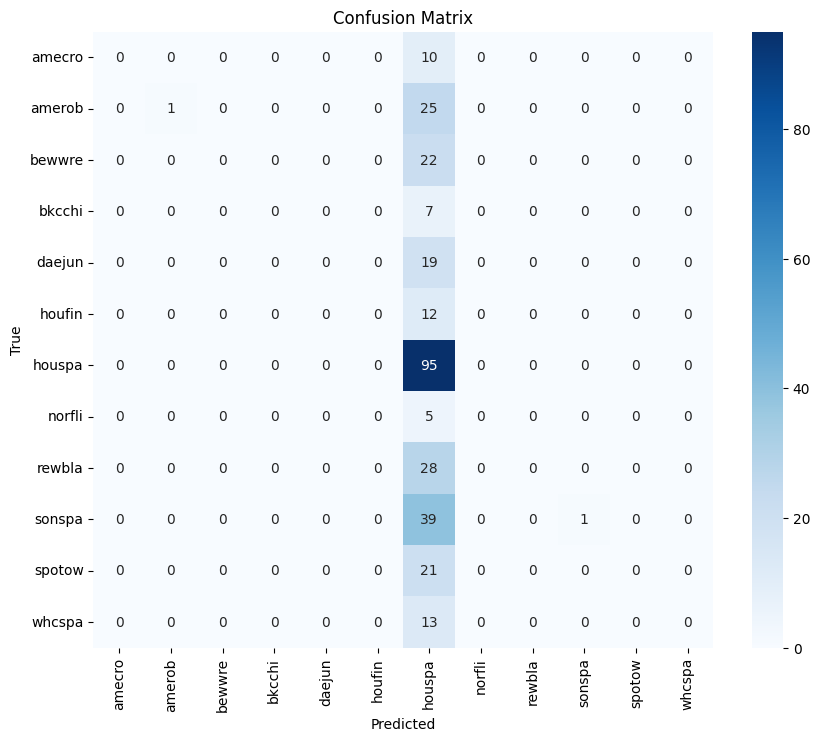

In [ ]:
#  Imports
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#  Load Data
h5_file = '/content/drive/MyDrive/bird_spectrograms.hdf5'
f = h5py.File(h5_file, 'r')

species_list = list(f.keys())
print(f"Species: {species_list}")

X_list = []
y_list = []

for idx, species in enumerate(species_list):
    data = f[species][:]
    data = np.transpose(data, (2, 0, 1))
    X_list.append(data)
    y_list.append(np.full(data.shape[0], idx))

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print(f"Total samples: {X.shape[0]}")

# Log Scaling Check
print(f"Spectrogram Min: {X.min():.4f}, Max: {X.max():.4f}")

if X.min() >= 0 and X.max() > 10:
    print("Applying log1p compression (linear scale detected)")
    X = np.log1p(X)
else:
    print("Skipping log1p (already log-scaled spectrogram detected)")

#  Normalize per sample
X = (X - X.min(axis=(1, 2), keepdims=True)) / (X.max(axis=(1, 2), keepdims=True) - X.min(axis=(1, 2), keepdims=True) + 1e-8)

# Add channel dimension
X = X[..., np.newaxis]  # Shape: (No. of samples, 128, 517, 1)

#  Train-Val-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


#  One-hot encode labels
num_classes = len(species_list)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

#  CNN Model
model = Sequential([
    InputLayer(shape=(128, 517, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

#  Train Model
history = model.fit(X_train, y_train_cat,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_val, y_val_cat),
                    verbose=2)

# Evaluate Test Set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

#  Classification Report
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=species_list))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=species_list, yticklabels=species_list)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


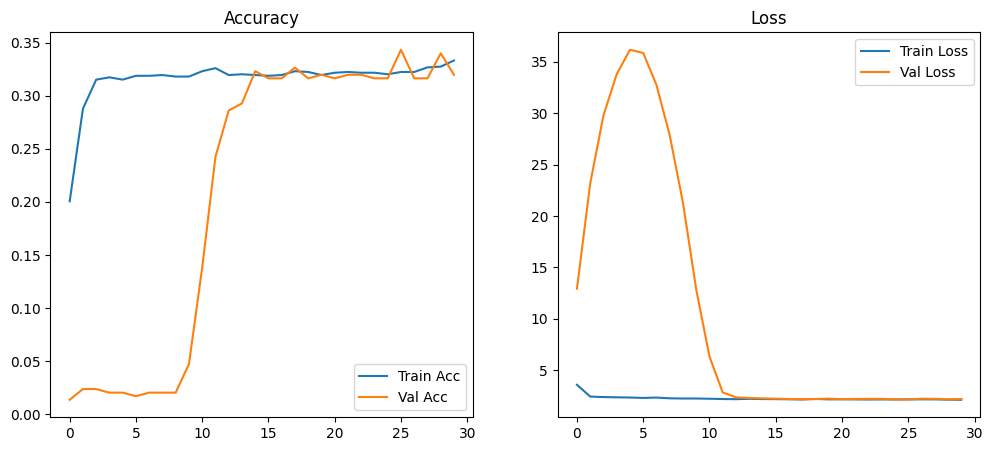

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot accuracy and Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/best_12species_model.keras')


In [ ]:
model.save('/content/drive/MyDrive/best_12species_model.h5')


PART 3 : TESTS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


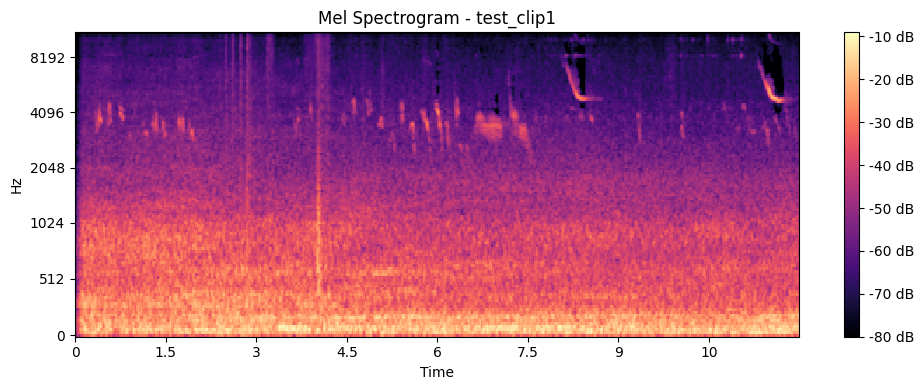

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


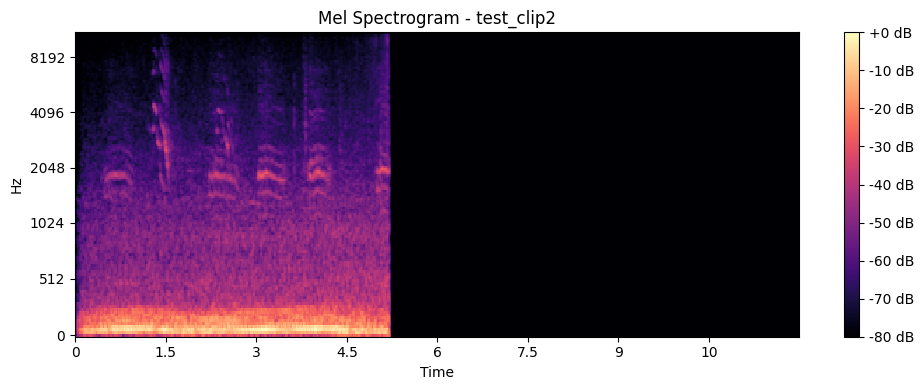

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


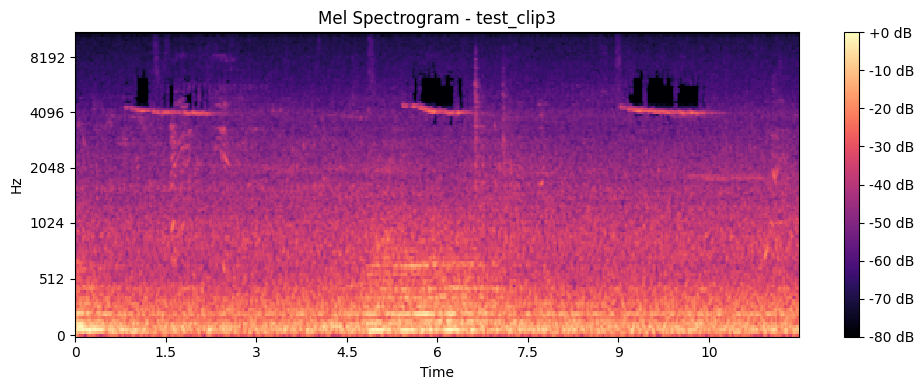


Prediction Results:

test_clip1:
  Top 1: houspa (0.17)
  Top 2: sonspa (0.10)
  Top 3: rewbla (0.10)

test_clip2:
  Top 1: houspa (0.09)
  Top 2: sonspa (0.09)
  Top 3: rewbla (0.09)

test_clip3:
  Top 1: houspa (0.15)
  Top 2: sonspa (0.10)
  Top 3: rewbla (0.10)


In [ ]:
#  Imports
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

#  Loading Trained Model
model = tf.keras.models.load_model('/content/drive/MyDrive/best_12species_model.h5')

#  Parameters
SAMPLE_RATE = 22050
N_MELS = 128
HOP_LENGTH = 512
SPEC_TIME_FRAMES = 517

#  Processing MP3 to Spectrogram
def process_audio_clip(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)

    # Generate Mel Spectrogram (log)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
    S_db = librosa.power_to_db(S, ref=np.max)

    # Trim to TIME FRAMES
    if S_db.shape[1] < SPEC_TIME_FRAMES:
        pad_width = SPEC_TIME_FRAMES - S_db.shape[1]
        S_db = np.pad(S_db, ((0, 0), (0, pad_width)), mode='constant', constant_values=-80)
    else:
        S_db = S_db[:, :SPEC_TIME_FRAMES]

    # Normalize (Min-Max per sample)
    S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-8)
    S_norm = S_norm[..., np.newaxis]  # Channel dimension

    return S_norm, S_db

#  Test Clips
test_clips = {
    'test_clip1': '/content/drive/MyDrive/test1.mp3',
    'test_clip2': '/content/drive/MyDrive/test2.mp3',
    'test_clip3': '/content/drive/MyDrive/test3.mp3'
}

predictions = {}

for clip_name, file_path in test_clips.items():
    X_clip, S_db = process_audio_clip(file_path)
    X_clip = np.expand_dims(X_clip, axis=0)  # Batch dimension

    probs = model.predict(X_clip)[0]
    predicted_indices = np.argsort(probs)[::-1][:3]  # Top 3

    predictions[clip_name] = {
        'top_classes': predicted_indices,
        'top_probs': probs[predicted_indices]
    }

    # Plot Spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - {clip_name}')
    plt.tight_layout()
    plt.show()

# Output :
species_list = ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin',
                'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']

print("\nPrediction Results:")
for clip, result in predictions.items():
    print(f"\n{clip}:")
    for idx, (cls_idx, prob) in enumerate(zip(result['top_classes'], result['top_probs'])):
        print(f"  Top {idx+1}: {species_list[cls_idx]} ({prob:.2f})")


<class 'dict'>
dict_keys(['test_clip1', 'test_clip2', 'test_clip3'])
test_clip1
<class 'numpy.ndarray'>
(128, 1003)


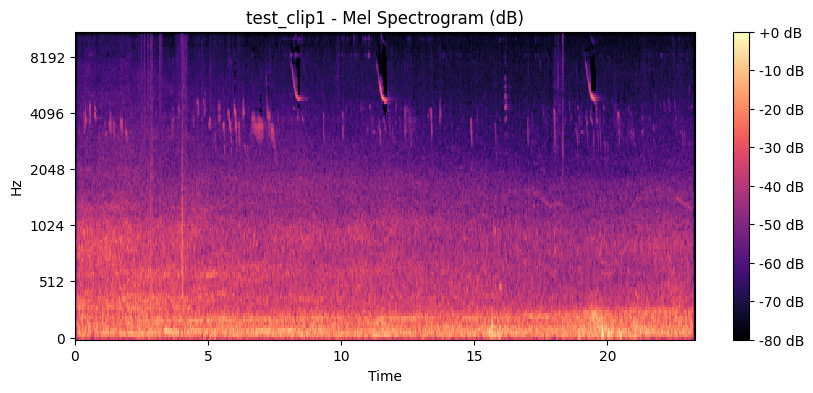

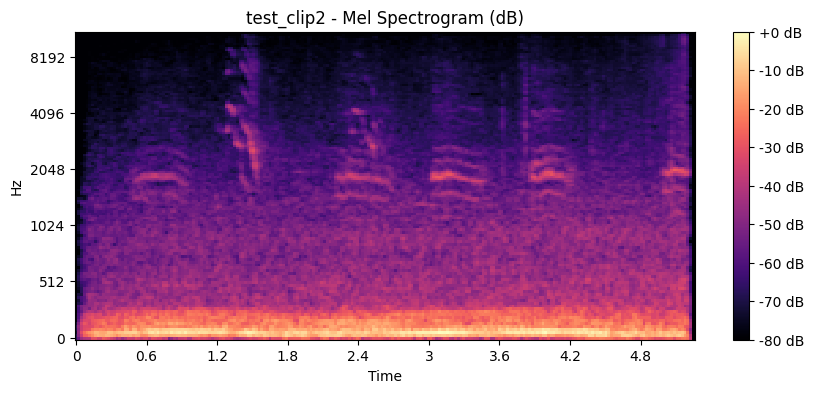

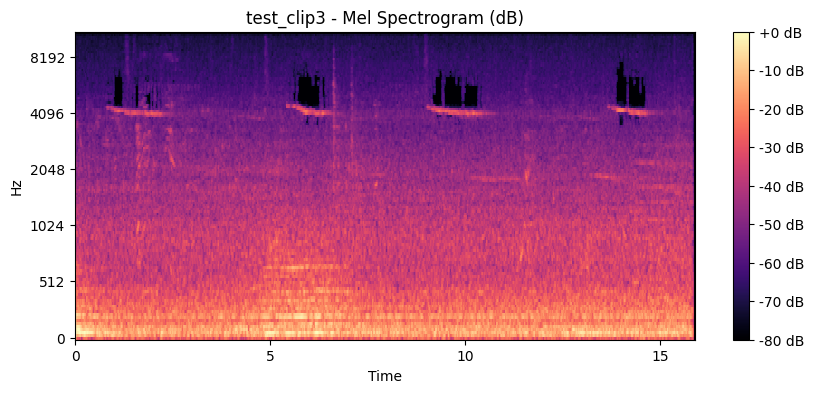

In [ ]:
print(type(test_clips))
print(test_clips.keys())

import librosa

for key, audio_path in test_clips.items():
    y, sr = librosa.load(audio_path, sr=22050)  # load audio from path
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    test_clips[key] = S_dB  # replace path string with spectrogram array


# To check type and shape of the first clip:
first_key = list(test_clips.keys())[0]
print(first_key)  # e.g., 'clip1'
print(type(test_clips[first_key]))  # should be numpy.ndarray
print(test_clips[first_key].shape)

# To plot each clip spectrogram properly:
import matplotlib.pyplot as plt
import librosa.display

for key, clip in test_clips.items():
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(clip, sr=22050, hop_length=512, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{key} - Mel Spectrogram (dB)")
    plt.show()


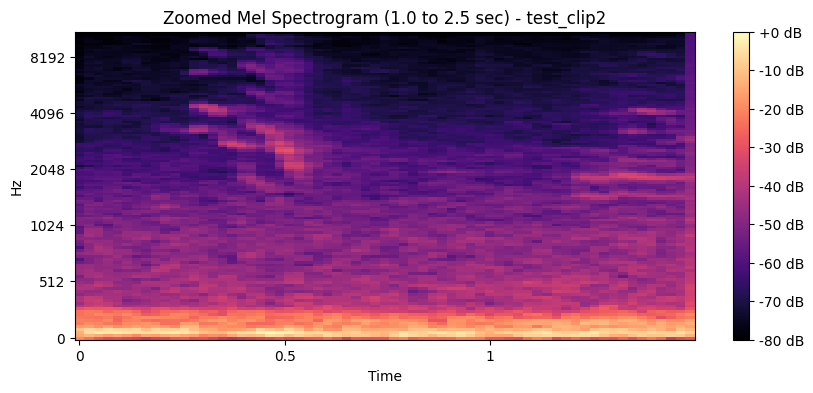

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Choose a time window in seconds to zoom in
start_time = 1.0
end_time = 2.5

sr = 22050  # sample rate
start_sample = int(start_time * sr)
end_sample = int(end_time * sr)

clip2_audio = librosa.load('/content/drive/MyDrive/test2.mp3', sr=sr)[0]
clip2_segment = clip2_audio[start_sample:end_sample]

# Compute mel spectrogram for zoomed segment
S_segment = librosa.feature.melspectrogram(y=clip2_segment, sr=sr, n_fft=2048, hop_length=512)
S_dB_segment = librosa.power_to_db(S_segment, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB_segment, sr=sr, hop_length=512, x_axis='time', y_axis='mel', cmap='magma')
plt.title("Zoomed Mel Spectrogram (1.0 to 2.5 sec) - test_clip2")
plt.colorbar(format='%+2.0f dB')
plt.show()
